In [9]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_unit_obs_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft'])

#merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
#merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

In [10]:
merged[['assoc_name_final','quarter','ln_sold_price_sq_ft']].head()

,assoc_name_final,quarter,ln_sold_price_sq_ft
0,"ORIOLE VILLAGES CENTER, INC. 33446",2022-10-01,5.183907
8,"ONE BARBADOS CONDOMINIUM ASSOCIATION, INC. 33606",2020-01-01,6.099611
9,BAYFRONT TOWER CONDO 33701,2021-01-01,6.619274
10,BAYFRONT TOWER CONDO 33701,2021-01-01,6.564987
11,BAYFRONT TOWER CONDO 33701,2023-01-01,6.720878


In [11]:
# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

In [12]:
event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)

In [23]:
#value_counts = merged['event_time'].value_counts()
#print(value_counts)

In [13]:
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

In [14]:
# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_18116\1398399657.py:11: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0009
Estimator:                    PanelOLS   R-squared (Between):             -0.0022
No. Observations:                76552   R-squared (Within):              -0.0070
Date:                 Wed, Jan 21 2026   R-squared (Overall):             -0.0029
Time:                         11:30:42   Log-likelihood                -2.844e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.2330
Entities:                         6150   P-value                           0.0002
Avg Obs:                        12.447   Distribution:                F(27,70348)
Min Obs:                        1.0000                                           
Max Obs:                        880.00   F-statistic (robust):             1.9813
                

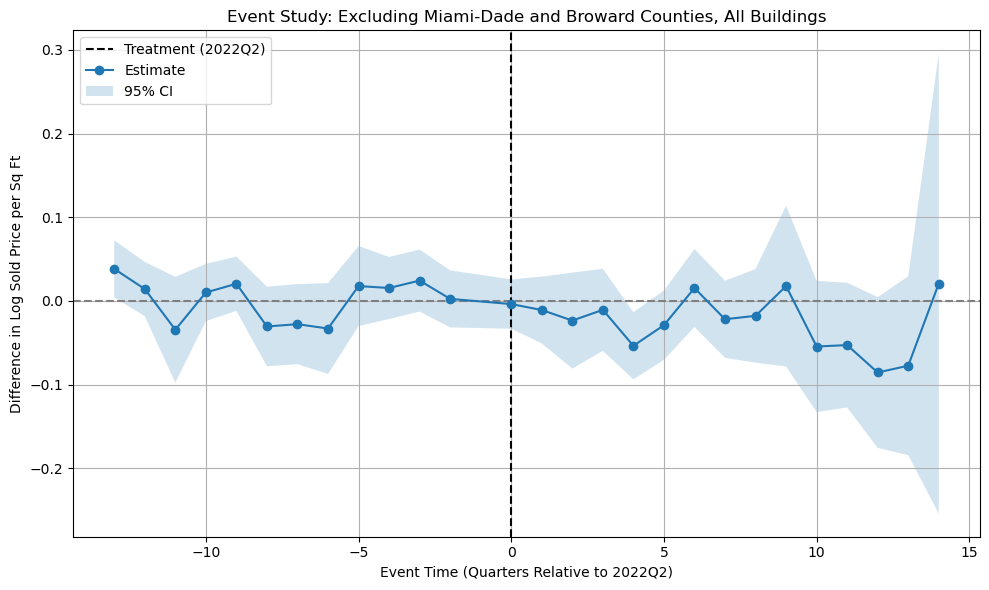

In [15]:
import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_sold_price/event_study_sprice_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\726735587.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0026
Estimator:                    PanelOLS   R-squared (Between):             -0.0096
No. Observations:                21599   R-squared (Within):               0.0393
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0068
Time:                         17:09:03   Log-likelihood                -1.916e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.9507
Entities:                         4037   P-value                           0.0042
Avg Obs:                        5.3503   Distribution:                F(23,17516)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             1.1761
                

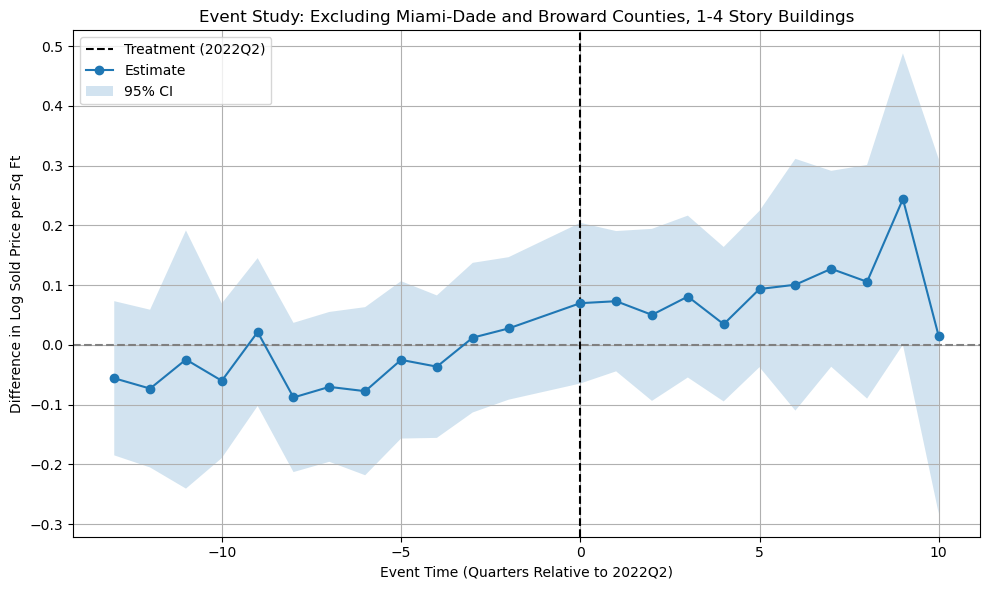

In [69]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_sold_price/event_study_sprice_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\244555185.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0056
Estimator:                    PanelOLS   R-squared (Between):             -0.0188
No. Observations:                13234   R-squared (Within):              -0.0751
Date:                 Wed, Jul 23 2025   R-squared (Overall):             -0.0226
Time:                         17:09:24   Log-likelihood                   -9302.8
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.6764
Entities:                         2237   P-value                           0.0000
Avg Obs:                        5.9160   Distribution:                F(23,10951)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             1.6614
                

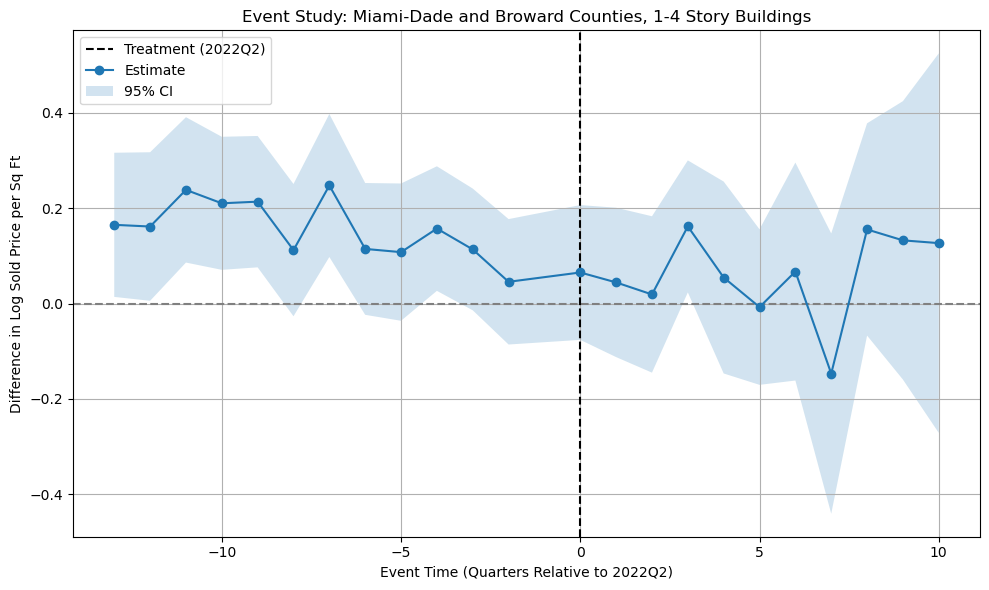

In [70]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_sold_price/event_study_sprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\3033833479.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0023
Estimator:                    PanelOLS   R-squared (Between):             -0.0183
No. Observations:                29315   R-squared (Within):               0.0717
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0079
Time:                         17:09:34   Log-likelihood                -4.399e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.5390
Entities:                         3557   P-value                           0.0001
Avg Obs:                        8.2415   Distribution:                F(23,25712)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             4.1487
                

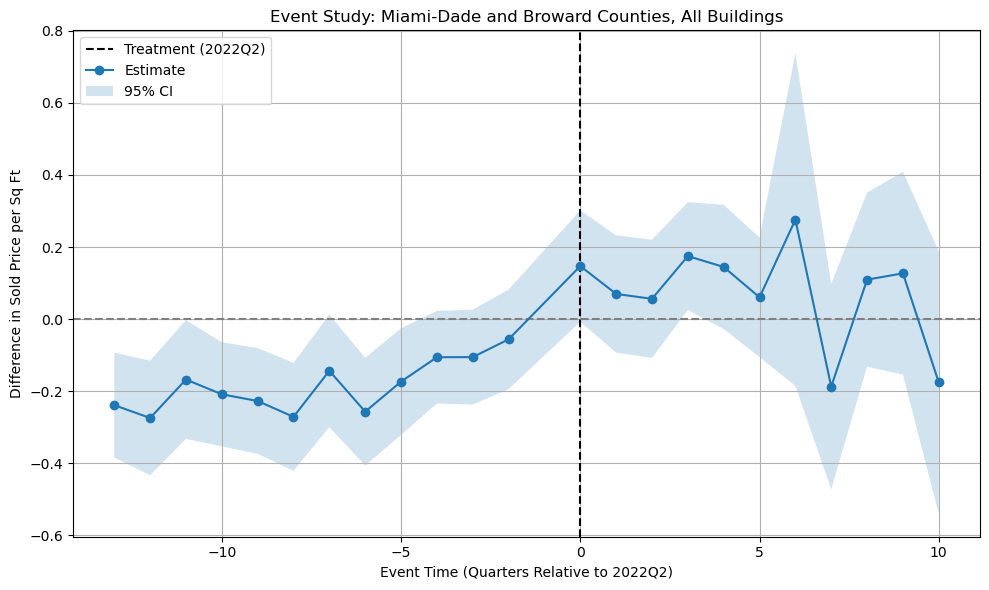

In [71]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_sold_price/event_study_sprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.2738
Estimator:                    PanelOLS   R-squared (Between):              0.1308
No. Observations:                26482   R-squared (Within):               0.2666
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.2627
Time:                         17:09:41   Log-likelihood                -5.161e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      268.13
Entities:                          114   P-value                           0.0000
Avg Obs:                        232.30   Distribution:                F(37,26308)
Min Obs:                        2.0000                                           
Max Obs:                        1958.0   F-statistic (robust):             28.021
                

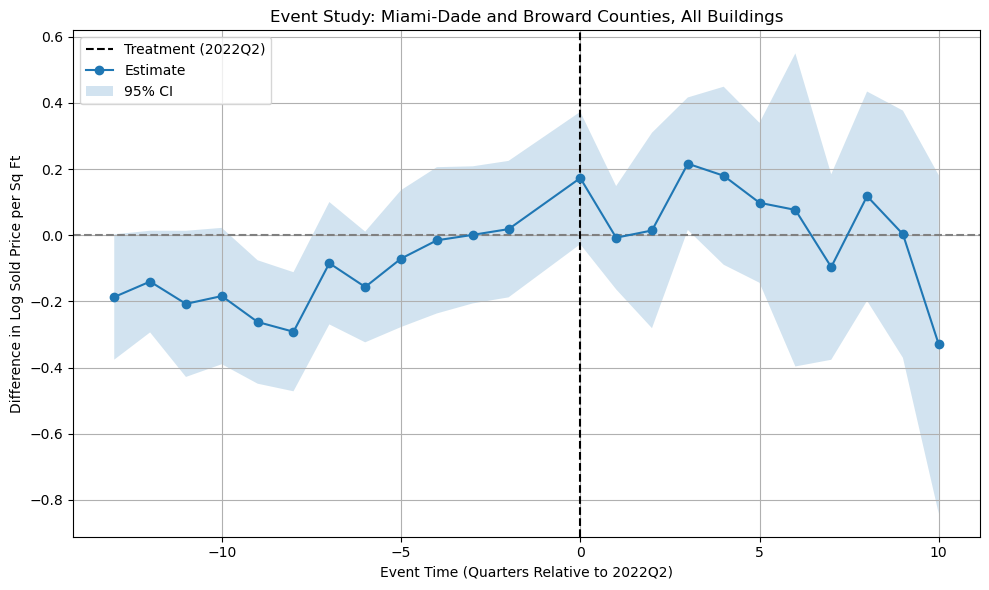

In [72]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_sold_price/event_study_sprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0834
Estimator:                    PanelOLS   R-squared (Between):              0.0218
No. Observations:                12434   R-squared (Within):               0.0352
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0149
Time:                         17:09:48   Log-likelihood                -1.611e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      30.180
Entities:                          109   P-value                           0.0000
Avg Obs:                        114.07   Distribution:                F(37,12265)
Min Obs:                        2.0000                                           
Max Obs:                        1021.0   F-statistic (robust):             18.418
                

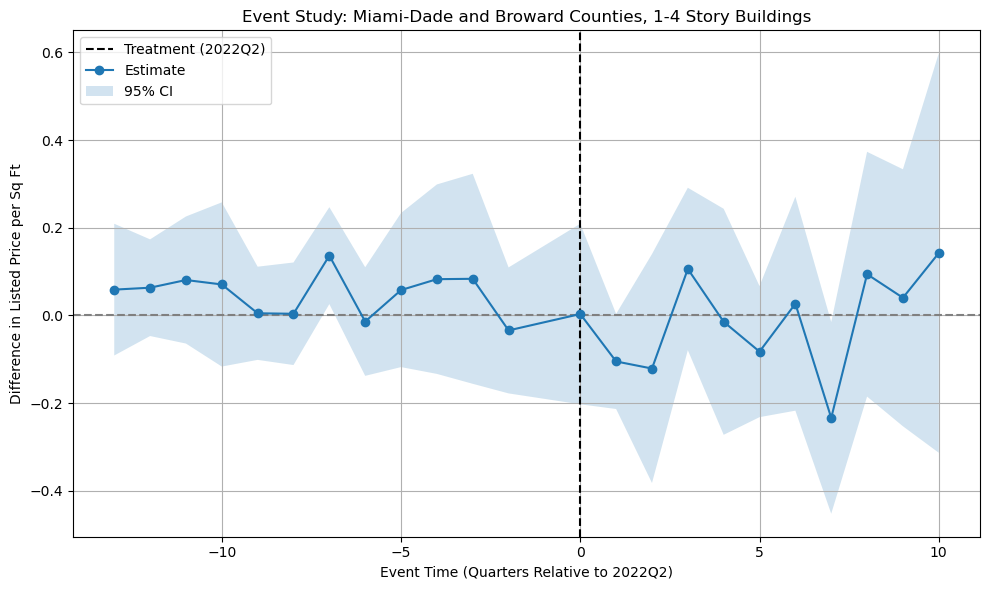

In [73]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_sold_price/event_study_sprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0742
Estimator:                    PanelOLS   R-squared (Between):             -0.0762
No. Observations:                29155   R-squared (Within):               0.1156
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.1419
Time:                         17:09:54   Log-likelihood                -5.503e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      62.194
Entities:                          391   P-value                           0.0000
Avg Obs:                        74.565   Distribution:                F(37,28704)
Min Obs:                        1.0000                                           
Max Obs:                        550.00   F-statistic (robust):             8.2843
                

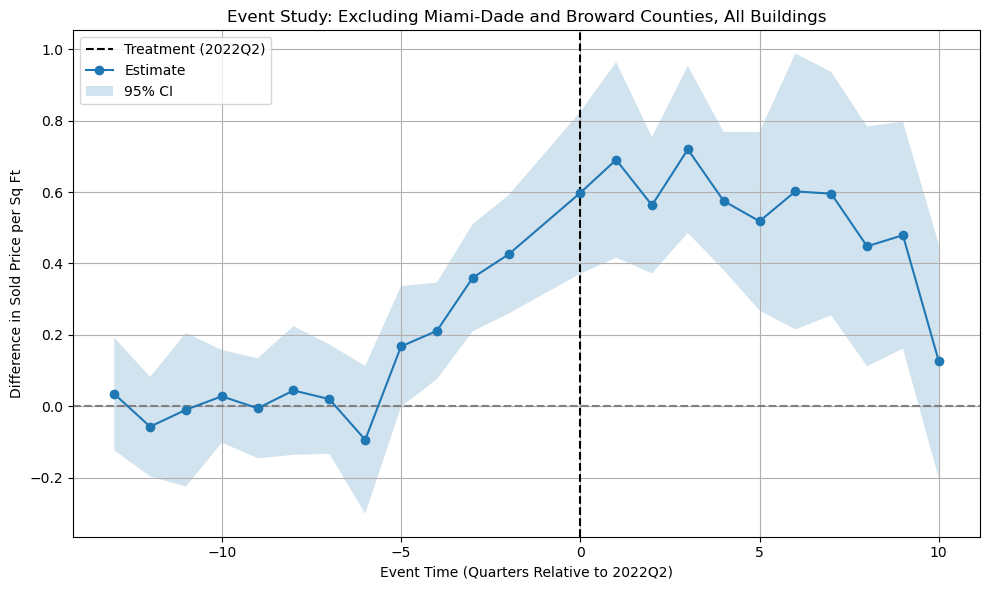

In [74]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_sold_price/event_study_sprice_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0531
Estimator:                    PanelOLS   R-squared (Between):              0.0797
No. Observations:                16453   R-squared (Within):               0.0485
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0951
Time:                         17:10:10   Log-likelihood                 -2.33e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      24.295
Entities:                          379   P-value                           0.0000
Avg Obs:                        43.412   Distribution:                F(37,16014)
Min Obs:                        1.0000                                           
Max Obs:                        354.00   F-statistic (robust):             3.8684
                

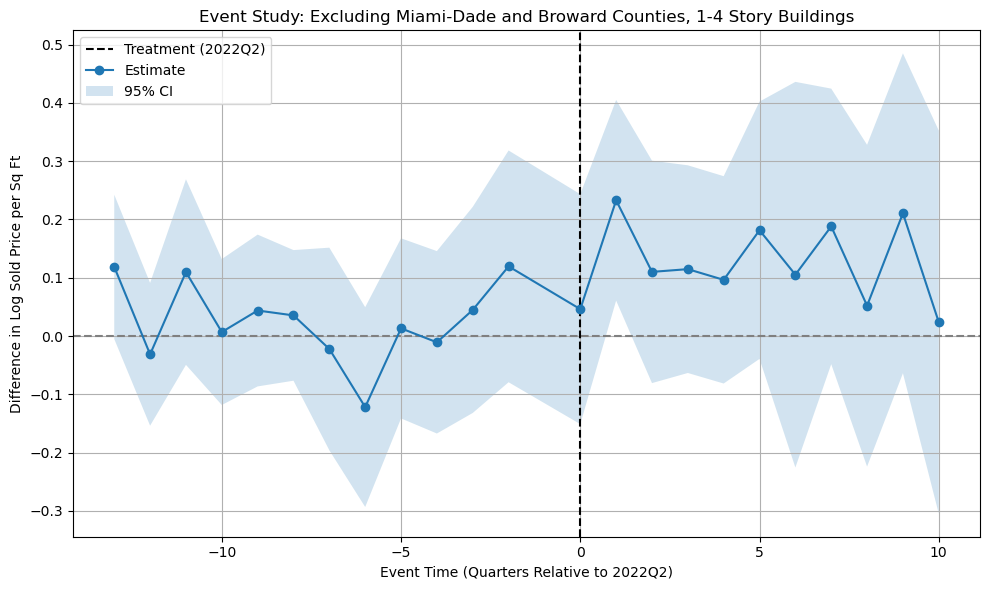

In [75]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_sold_price/event_study_sprice_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\4246551169.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0056
Estimator:                    PanelOLS   R-squared (Between):             -0.0121
No. Observations:                13234   R-squared (Within):              -0.0751
Date:                 Wed, Jul 23 2025   R-squared (Overall):             -0.0134
Time:                         17:10:24   Log-likelihood                   -9302.8
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.6764
Entities:                         2237   P-value                           0.0000
Avg Obs:                        5.9160   Distribution:                F(23,10951)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             1.6614
                

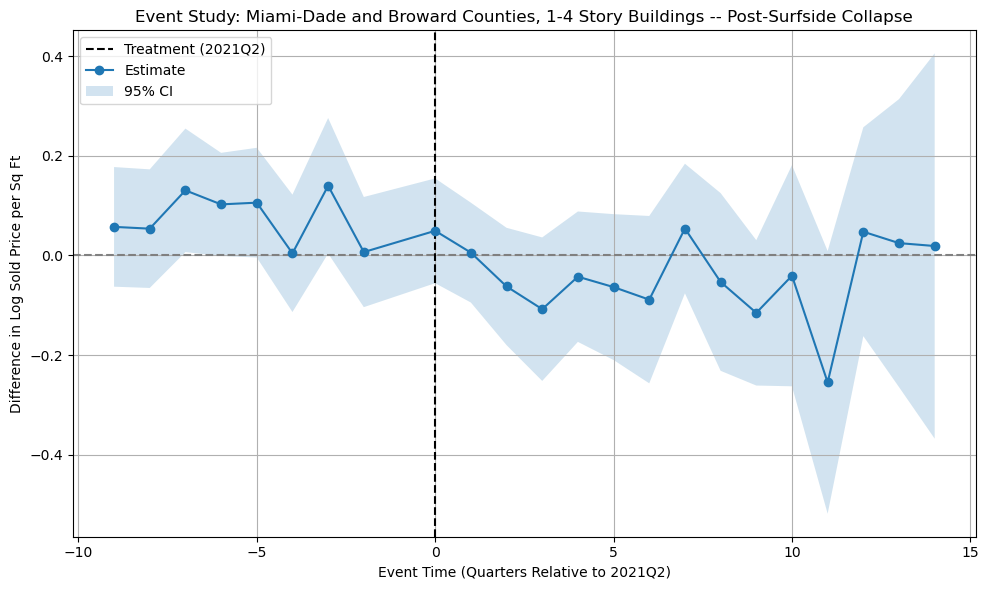

In [76]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Log Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_sold_price/assoc_fe/event_study_surfside_sprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\438410272.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0023
Estimator:                    PanelOLS   R-squared (Between):             -0.0053
No. Observations:                29315   R-squared (Within):               0.0717
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0137
Time:                         17:10:38   Log-likelihood                -4.399e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.5390
Entities:                         3557   P-value                           0.0001
Avg Obs:                        8.2415   Distribution:                F(23,25712)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             4.1487
                

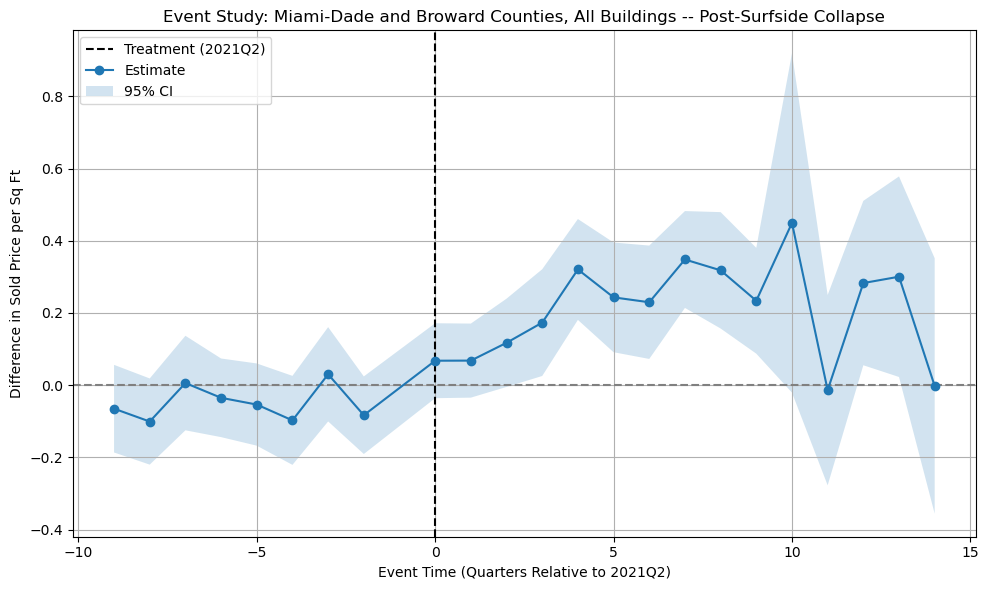

In [77]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_sold_price/assoc_fe/event_study_surfside_sprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0696
Estimator:                    PanelOLS   R-squared (Between):              0.0255
No. Observations:                13234   R-squared (Within):               0.0222
Date:                 Wed, Jul 23 2025   R-squared (Overall):             -0.0178
Time:                         17:11:05   Log-likelihood                -1.709e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      28.735
Entities:                          110   P-value                           0.0000
Avg Obs:                        120.31   Distribution:                F(34,13067)
Min Obs:                        2.0000                                           
Max Obs:                        1039.0   F-statistic (robust):             18.566
                

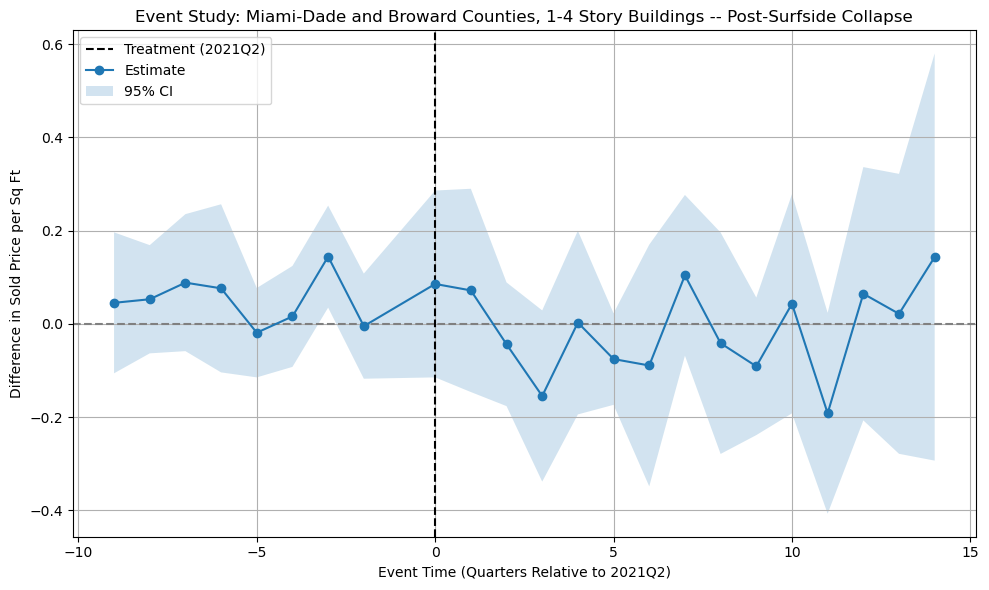

In [78]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_sold_price/zip_fe/event_study_surfside_sprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.2107
Estimator:                    PanelOLS   R-squared (Between):              0.0256
No. Observations:                29315   R-squared (Within):               0.2084
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.1611
Time:                         17:11:21   Log-likelihood                -6.262e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      228.80
Entities:                          115   P-value                           0.0000
Avg Obs:                        254.91   Distribution:                F(34,29143)
Min Obs:                        2.0000                                           
Max Obs:                        2298.0   F-statistic (robust):             21.002
                

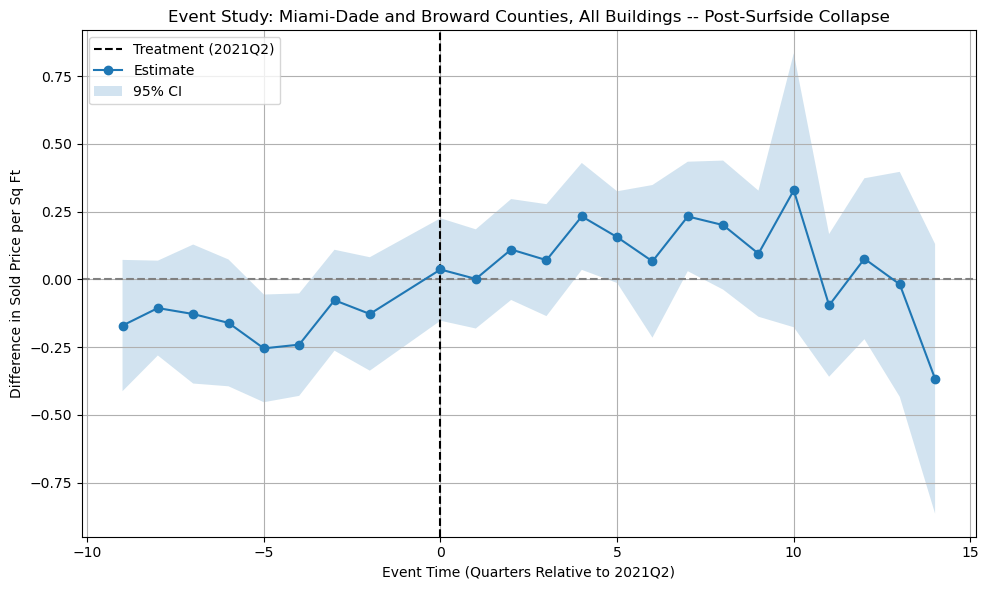

In [79]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_sold_price/zip_fe/event_study_surfside_sprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_31576\2968989869.py:87: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr, fema_2.0, fema_3.0

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_sold_price_sq_ft   R-squared:                        0.0027
Estimator:                    PanelOLS   R-squared (Between):             -0.0021
No. Observations:                17237   R-squared (Within):               0.0801
Date:                 Wed, Jul 30 2025   R-squared (Overall):              0.0193
Time:                         18:09:12   Log-likelihood                -2.987e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.7600
Entities:                         1997   P-value                           0.0137
Avg Obs:                        8.6314   Distribution:                F(23,15194)
Min Obs:                        1.0000                                           
Max Obs:                        25.000   F-statistic (robust):             3.3788
                

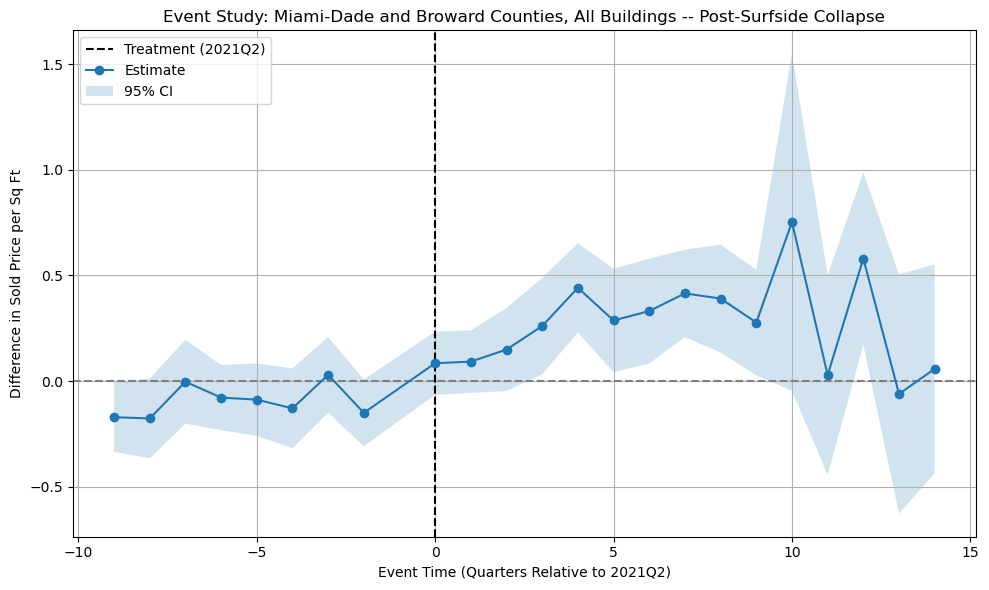

In [82]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['three_miles_coast_assoc'].notna()) & (merged['three_miles_coast_assoc'] == 1)]
# merged = merged[(merged['property_age_assoc_qtr'].notna()) & (merged['property_age_assoc_qtr'] <= 30)]

fema_flood_dummies = pd.get_dummies(
    merged['fema_flood_risk_bucket_assoc'], 
    prefix='fema', 
    drop_first=True
)

firststreet_flood_dummies = pd.get_dummies(
    merged['firststreet_risk_cat_assoc'], 
    prefix='firststreet', 
    drop_first=True
)

merged = merged.join(fema_flood_dummies)
merged = merged.join(firststreet_flood_dummies)


# merged['ln_sold_price_sq_ft'] = np.log(merged['sold_price_sq_ft_assoc_qtr'])
merged['ln_sold_price_sq_ft'] = merged['sold_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_sold_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'fema_2.0', 'fema_3.0'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Sold Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
# plt.savefig('output/plot_surfside_sold_price/zip_fe/event_study_surfside_sprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()